In [1]:
%load_ext autoreload
%autoreload 2

In [126]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import lime
from lime import lime_image
from lime import submodular_pick
import matplotlib.pyplot as plt
import IPython.display as display
from tensorflow.keras.models import Model
%matplotlib inline

In [3]:
import sys
sys.path.append('..')
from dataset import batcher

In [43]:
MODEL_DIR = '../saved_models/'
TFRECORDS_DIR = '../data/eth_lsms_tfrecords/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']
COUNTRIES = ['ethiopia-2018', 'nigeria-2018', 'malawi-2016', 'pollution-2018']

In [82]:
# avg_rad is the nightlights band
BANDS = ['RED', 'GREEN', 'BLUE', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']

In [12]:
test_batcher = batcher.Batcher(BANDS, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 10)


In [115]:
# Load model
experiments = ['imagery_sample_cnn_regression_2560.001gelu']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [116]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

In [83]:
def get_feature_array(feature_set):
    result = {}
    for key, feature in feature_set.items():
        kind = feature.WhichOneof('kind')
        shape = np.array(getattr(feature, kind).value).shape
        result[key] = kind, shape
       
    return result

def create_single_feature_set(filename):
    record = tf.data.TFRecordDataset(filenames=[filename])
    feature_set = parse_features(record=record)
    
    return feature_set

def parse_features(record):
    raw_example = next(iter(record)) 
    example = tf.train.Example.FromString(raw_example.numpy())
    
    return example.features.feature

In [323]:
"""
Good images to demo:
ethiopia_0_8.tfrecord - good amount of everything
ethiopia_0_6.tfrecord - has low pop. so activations are interesting
ethiopia_0_9.tfrecord - big settlement in middle, activations
ethiopia_1_13.tfrecord - small village, agriculture, good activations
ethiopia_5_16.tfrecord - lots of agriculure
"""
# First TFRecord path
sample_tfrecord = TFRECORDS_DIR + 'ethiopia_0_9.tfrecord'

# Get feature array of first record
feature_set = create_single_feature_set(filename=sample_tfrecord)
get_feature_array(feature_set=feature_set)

{'DELTA_TEMP': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'CO': ('float_list', (65025,)),
 'VIIRS': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'SW_IR2': ('float_list', (65025,)),
 'density': ('float_list', (1,)),
 'BLUE': ('float_list', (65025,)),
 'lat': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'RED': ('float_list', (65025,)),
 'consumption': ('float_list', (1,)),
 'SW_IR1': ('float_list', (65025,)),
 'country': ('bytes_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'TEMP': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,))}

In [324]:
band_images = []
for band_id, band_name in enumerate(BANDS):
    band = np.array(feature_set[band_name].float_list.value, dtype=np.float32).reshape(255, 255)
    band_images.append(band)
band_images = np.stack(band_images, axis=2)
print(np.shape(band_images))
bands = {band_name: band_images[:, :, b] for b, band_name in enumerate(BANDS)}

(255, 255, 10)


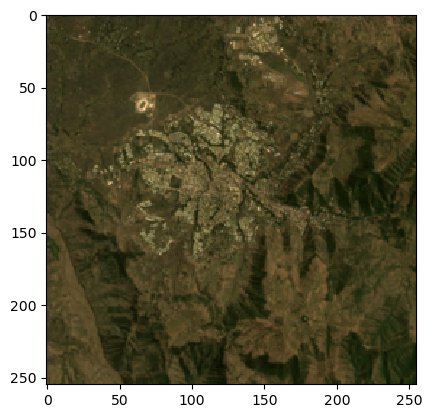

In [325]:
r, g, b = bands['RED'], bands['GREEN'], bands['BLUE']
rgb = np.stack([r, g, b], axis=2)

scaled_rgb = ((rgb - rgb.min()) * (1/(rgb.max() - rgb.min()) * 255)).astype('uint8')

plt.imshow(scaled_rgb, interpolation='nearest')
plt.show()

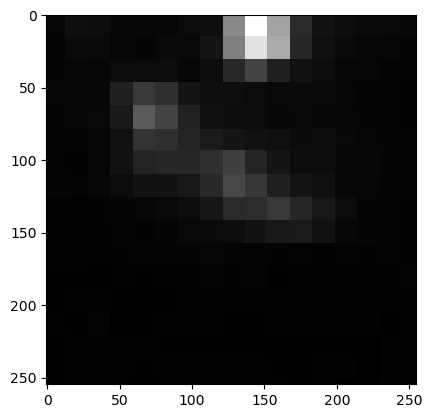

In [328]:
nightlights = bands["VIIRS"]

scaled_nightlights = ((nightlights - nightlights.min()) * (1/(nightlights.max() - nightlights.min()) * 255)).astype('uint8')

plt.imshow(scaled_nightlights, interpolation='nearest', cmap="gray")
plt.show()

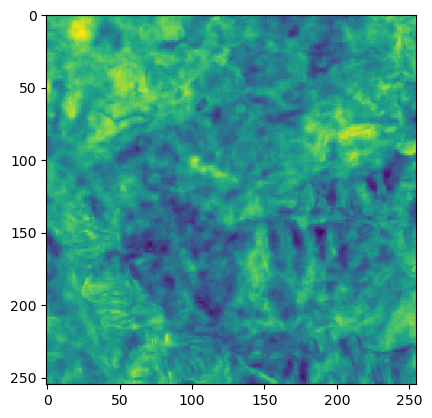

In [327]:
delta_temp = bands["DELTA_TEMP"]

scaled_delta_temp = ((delta_temp - delta_temp.min()) * (1/(delta_temp.max() - delta_temp.min()) * 255)).astype('uint8')

plt.imshow(scaled_delta_temp, interpolation='nearest')
plt.show()

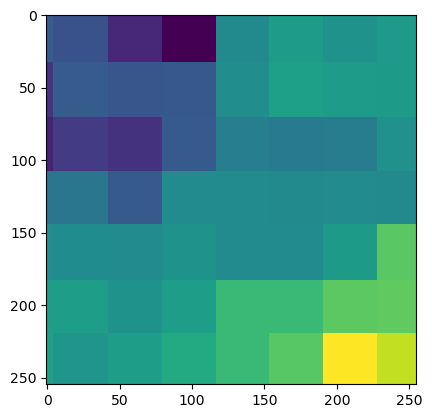

In [314]:
co = bands["CO"]

scaled_co = ((co - co.min()) * (1/(co.max() - co.min()) * 255)).astype('uint8')

plt.imshow(scaled_co, interpolation='nearest')
plt.show()

In [315]:
cropped_band_images = []
for key in bands:
    band = bands.get(key)
    band = tf.reshape(band, [255, 255])[15:239, 15:239]
    cropped_band_images.append(band)

stacked = tf.stack(cropped_band_images, axis=0)
# Convert from CHW to HWC
stacked = tf.transpose(stacked, [1, 2, 0]).numpy()
stacked = stacked.reshape(1, 224, 224, 10)
print(np.shape(stacked))

(1, 224, 224, 10)


In [316]:
for layer in trained_model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_645 (3, 3, 10, 32)
conv2d_646 (3, 3, 32, 32)
conv2d_647 (3, 3, 32, 64)
conv2d_648 (3, 3, 64, 64)
conv2d_649 (3, 3, 64, 128)
conv2d_650 (3, 3, 128, 128)
conv2d_651 (3, 3, 128, 256)
conv2d_652 (3, 3, 256, 256)
conv2d_653 (3, 3, 256, 256)
conv2d_654 (3, 3, 256, 512)
conv2d_655 (3, 3, 512, 512)
conv2d_656 (3, 3, 512, 512)
conv2d_657 (3, 3, 512, 512)
conv2d_658 (3, 3, 512, 512)
conv2d_659 (3, 3, 512, 512)


In [317]:
# retrieve weights from the second hidden layer
filters , bias = trained_model.layers[1].get_weights()

In [318]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

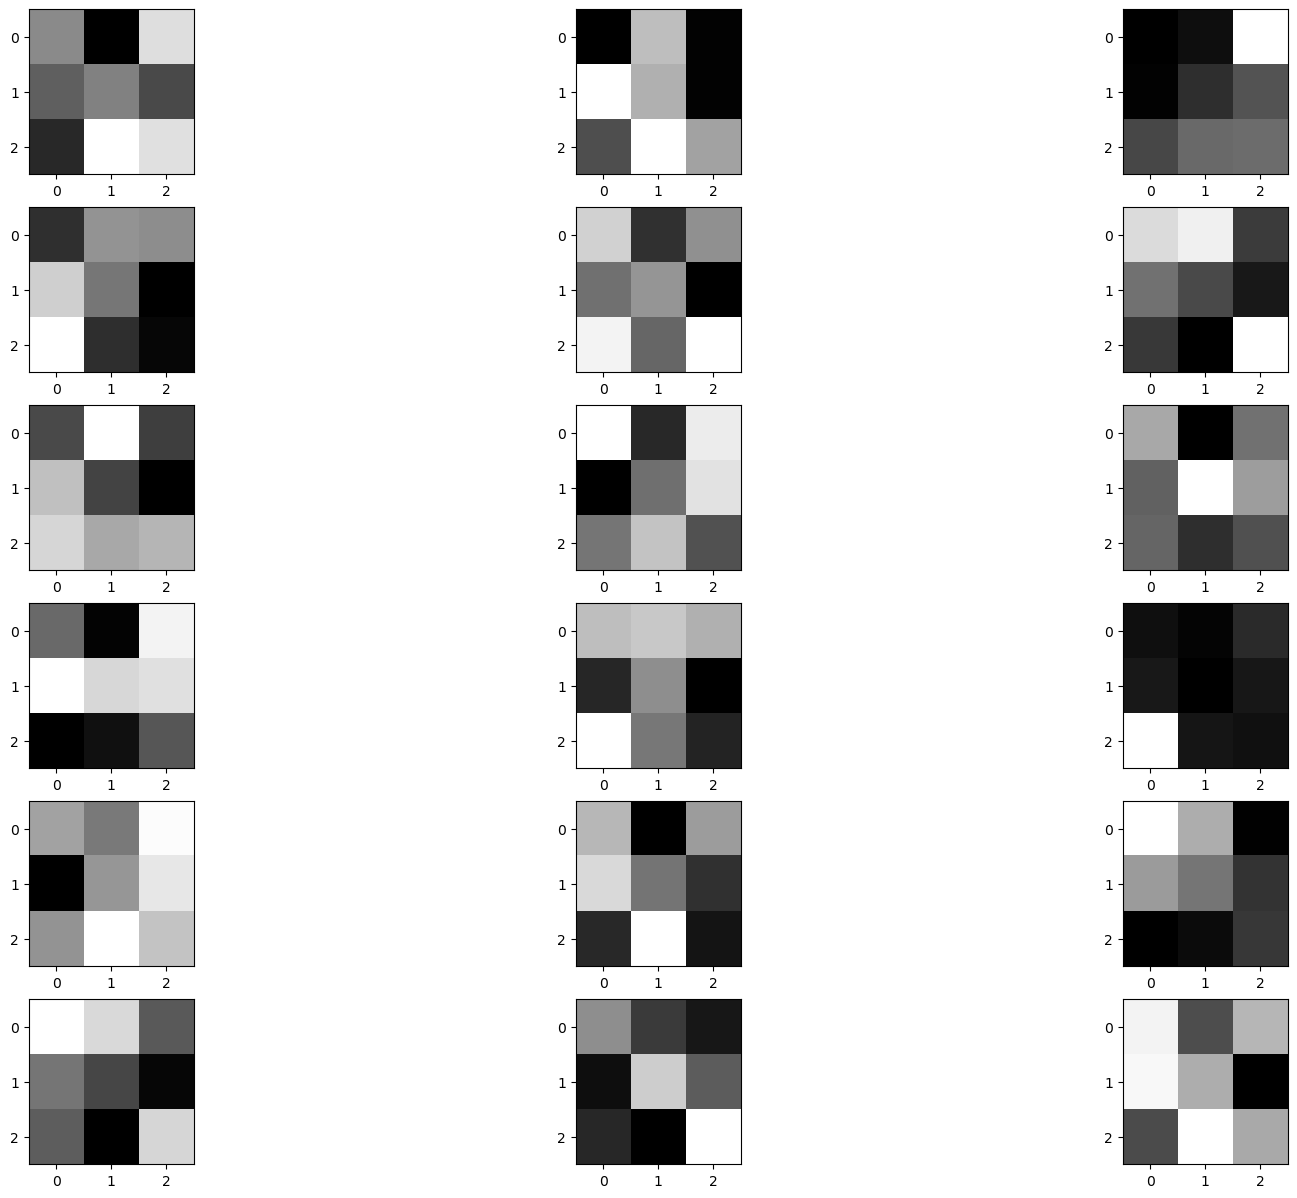

In [319]:
n_filters = 6
ix = 1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix += 1
#plot the filters 
plt.show()

In [320]:
print("Input shape: " + str(trained_model.layers[0].input.shape))
for i in range(len(trained_model.layers)):
    layer = trained_model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

Input shape: (None, 224, 224, 10)
0 conv2d_645 (None, 224, 224, 32)
1 conv2d_646 (None, 224, 224, 32)
5 conv2d_647 (None, 112, 112, 64)
6 conv2d_648 (None, 112, 112, 64)
10 conv2d_649 (None, 56, 56, 128)
11 conv2d_650 (None, 56, 56, 128)
15 conv2d_651 (None, 28, 28, 256)
16 conv2d_652 (None, 28, 28, 256)
17 conv2d_653 (None, 28, 28, 256)
21 conv2d_654 (None, 14, 14, 512)
22 conv2d_655 (None, 14, 14, 512)
23 conv2d_656 (None, 14, 14, 512)
27 conv2d_657 (None, 7, 7, 512)
28 conv2d_658 (None, 7, 7, 512)
29 conv2d_659 (None, 7, 7, 512)


In [321]:
model = Model(inputs=trained_model.inputs , outputs=trained_model.layers[1].output)

(1, 224, 224, 10)
1/1 [==============================] - 0s 50ms/step


2023-06-03 16:54:56.128752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


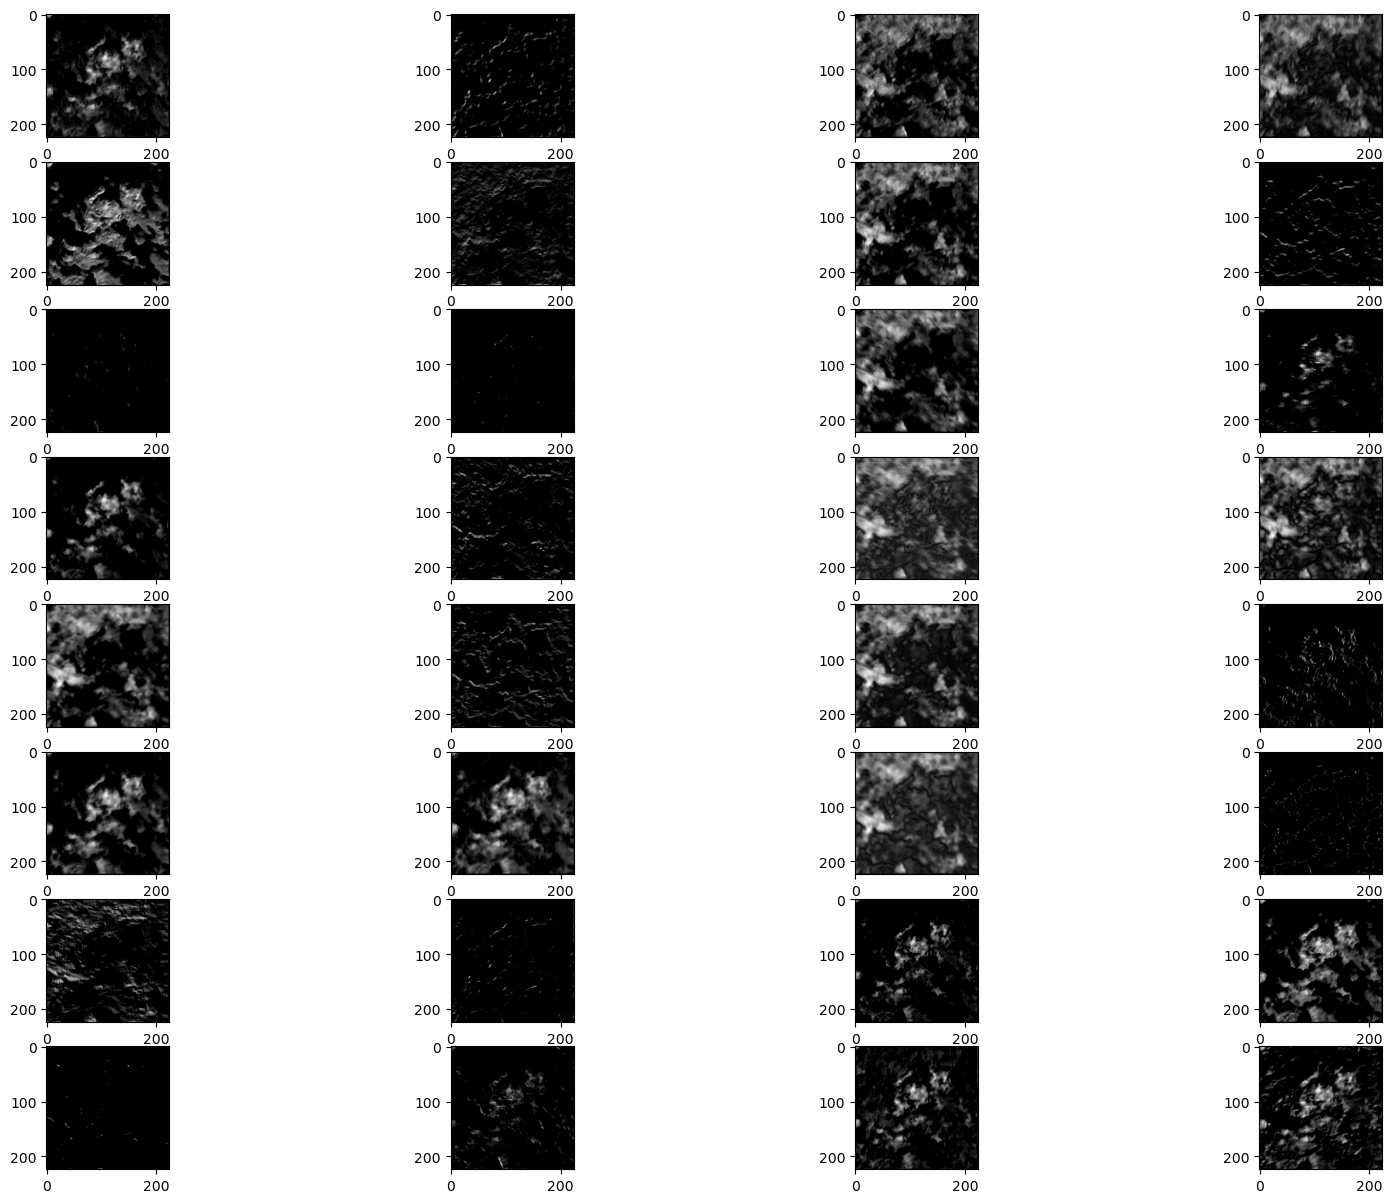

In [322]:
print(np.shape(stacked))
#calculating features_map
features = model.predict(stacked)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,4,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()